In [73]:
import traci
import pandas as pd
import numpy as np
from os import path, mkdir
import matplotlib.pyplot as plt 

def run(inputFile="../SUMO/algorithm/algorithm.sumocfg", outputFileName="output.csv", steps=500, shouldMakePlots=False):
    # initializations
    
    dtype = [('Step', int), ('PedestrianCount', float), ('AveragePeopleAtBusStops', float), ('AverageWaitTime', float)]
    data = np.zeros(steps, dtype=dtype)
    #data frame implementation - sometimes slower than numpy, experiment proved indecisive
    # data = pd.DataFrame(
    #     {
    #     "Step":[],
    #     "PedestrianCount": [],
    #     "AveragePeopleAtBusStops": [],
    #     "AverageWaitTime": [],
    #     }
    # )
    # Connect to SUMO simulation
    traci.start(["sumo", "-c", path.abspath(inputFile)])

    # simulation loop
    step = 0
    while step < steps:
        traci.simulationStep()
        
        persons = traci.person.getIDList()
        
        
        pedestrianCount = len(persons)
        averageWaitTime = getAverageWaitTime(persons)
        averagePeopleAtBusStops = getAveragePeopleAtBusStops()
        
        data['Step'][step] = step
        data['PedestrianCount'][step] = pedestrianCount
        data['AveragePeopleAtBusStops'][step] = averagePeopleAtBusStops
        data['AverageWaitTime'][step] = averageWaitTime
        # data.loc[len(data)] = {"Step": step, "PedestrianCount": pedestrianCount, "AveragePeopleAtBusStops": averagePeopleAtBusStops, "AverageWaitTime": averageWaitTime}
         
        step += 1
    if shouldMakePlots:
        makePlots(data)
    if (path.isdir("../Output") == False):
        mkdir("../Output")
    np.savetxt(f"../Output/{outputFileName}", data, delimiter=',',fmt='%f', header="Step,PedestrianCount,AveragePeopleAtBusStops,AverageWaitTime") 
    # data.to_csv(f"../Output/{outputFileName}", index=False)
    
def makePlots(data):
        # Plot for Pedestrian Count
        plt.figure()
        plt.plot(data['Step'], data['PedestrianCount'], label="Pedestrian Count")
        plt.legend()
        plt.xlabel("Simulation Steps")
        plt.ylabel("Count")
        plt.title("Pedestrian Count")
        plt.show()

        # Plot for Average People at Bus Stops
        plt.figure()
        plt.plot(data['Step'], data['AveragePeopleAtBusStops'], label="Average People at Bus Stops")
        plt.legend()
        plt.xlabel("Simulation Steps")
        plt.ylabel("Count")
        plt.title("Average People at Bus Stops")
        plt.show()

        # Plot for Average Wait Time
        plt.figure()
        plt.plot(data['Step'], data['AverageWaitTime'], label="Average Wait Time")
        plt.legend()
        plt.xlabel("Simulation Steps")
        plt.ylabel("Seconds")
        plt.title("Average Wait Time")
        plt.show()
        
def getAverageWaitTime(persons):
    personsWaitingTimeList = []
    numOfPersons = len(persons)
    for j in range(numOfPersons):
        personWaitingTime = traci.person.getWaitingTime(persons[j])
        personsWaitingTimeList.append(personWaitingTime)
    
    # finds average wait time
    length = len(personsWaitingTimeList)
    averageWaitTime = sum(personsWaitingTimeList)/length if length != 0 else 0
    return averageWaitTime
    
    
def getAveragePeopleAtBusStops():
    busStops = ["bs_road_-overlap","bs_road_-R2", "bs_road_-R1", "bs_road_-R0", "bs_road_-L3", "bs_road_-L2", "bs_road_-L1", "bs_road_-L0"] # excluding overlap for special case handling
    
    totalPeopleAtBusStops = 0
    ### finds the number of people at each bus stop
    for busStop in busStops:
        totalPeopleAtBusStops += traci.busstop.getPersonCount(busStop)
    return totalPeopleAtBusStops/len(busStops)
    

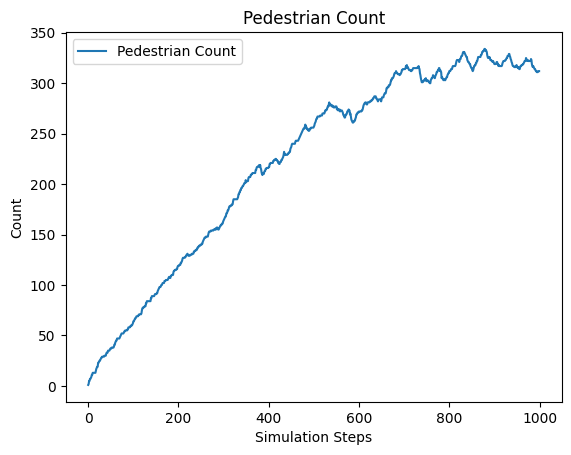

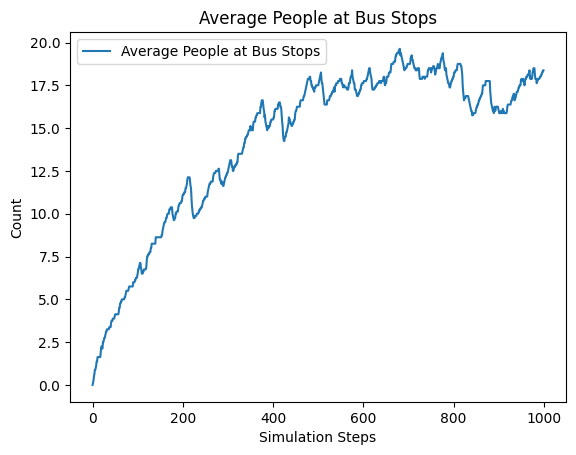

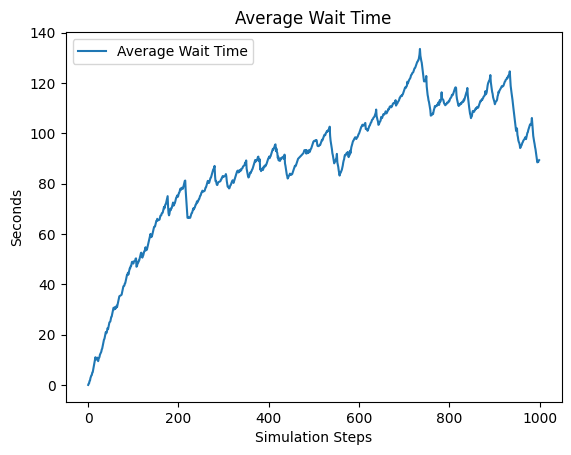

In [74]:

try:
    traci.close()
except:
    pass

try:
    run("../SUMO/schedule/schedule.sumocfg", "schedule_output.csv", 1000, True)
finally:
    traci.close()

In [77]:
from random import randint

In [78]:
#now for multiple runs, where the values are the average of the runs:
def runMultiple(inputFile="../SUMO/algorithm/algorithm.sumocfg", outputFileName="output.csv", steps=500, shouldMakePlots=False, runs=10):
    dtype = [('Step', int), ('PedestrianCount', float), ('AveragePeopleAtBusStops', float), ('AverageWaitTime', float)]
    data = np.zeros(steps, dtype=dtype)
    for run in range(runs):
        # Connect to SUMO simulation
        traci.start(["sumo", "-c", path.abspath(inputFile),f"--seed {randint(0, 1000000)}"])

        # simulation loop
        step = 0
        while step < steps:
            traci.simulationStep()
            
            persons = traci.person.getIDList()
            
            
            pedestrianCount = len(persons)
            averageWaitTime = getAverageWaitTime(persons)
            averagePeopleAtBusStops = getAveragePeopleAtBusStops()
            
            if run == 0:
                data['Step'][step] = step
            # if run == 800:
            #     print(data['PedestrianCount'][step])
            data['PedestrianCount'][step] += pedestrianCount
            data['AveragePeopleAtBusStops'][step] += averagePeopleAtBusStops
            data['AverageWaitTime'][step] += averageWaitTime
            # data.loc[len(data)] = {"Step": step, "PedestrianCount": pedestrianCount, "AveragePeopleAtBusStops": averagePeopleAtBusStops, "AverageWaitTime": averageWaitTime}
            
            step += 1
        traci.close()
        # print(run)
        # print(data['AverageWaitTime'][800])
    data['PedestrianCount'] = data['PedestrianCount']/runs
    data['AveragePeopleAtBusStops'] = data['AveragePeopleAtBusStops']/runs
    data['AverageWaitTime'] = data['AverageWaitTime']/runs
    if shouldMakePlots:
        makePlots(data)
    if (path.isdir("../Output") == False):
        mkdir("../Output")
    np.savetxt(f"../Output/{outputFileName}", data, delimiter=',',fmt='%f', header="Step,PedestrianCount,AveragePeopleAtBusStops,AverageWaitTime")

In [79]:
try:
    traci.close()
except:
    pass

try:
    runMultiple("../SUMO/schedule/schedule.sumocfg", "schedule_output_average.csv", 1000, True,5)
finally:
    traci.close()

C:\Program Files (x86)\Eclipse\Sumo\tools\traci\main.py:154: UserWarning: Could not connect to TraCI server using port 17713 (TraCI server already finished). Retrying with different port.
  warnings.warn(("Could not connect to TraCI server using port %s (%s)." +
C:\Program Files (x86)\Eclipse\Sumo\tools\traci\main.py:154: UserWarning: Could not connect to TraCI server using port 17723 (TraCI server already finished). Retrying with different port.
  warnings.warn(("Could not connect to TraCI server using port %s (%s)." +
C:\Program Files (x86)\Eclipse\Sumo\tools\traci\main.py:154: UserWarning: Could not connect to TraCI server using port 17730 (TraCI server already finished). Retrying with different port.
  warnings.warn(("Could not connect to TraCI server using port %s (%s)." +
C:\Program Files (x86)\Eclipse\Sumo\tools\traci\main.py:154: UserWarning: Could not connect to TraCI server using port 17737 (TraCI server already finished). Retrying with different port.
  warnings.warn(("Could

FatalTraCIError: Not connected.